In [17]:
import pygplates
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd

import pt_validation as ptv

import sys
sys.path.append('/Users/simon/GIT/GPlatesReconstructionModel/')
from reconstruction_classes import *
from raster_reconstruction_classes import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

reconstruction_basedir = '../../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
rotation_model = pygplates.RotationModel('%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir)

static_polygons = pygplates.FeatureCollection('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz')
#static_polygons = pygplates.FeatureCollection('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')

andesites = pd.read_excel('/Users/Simon/Data/TimeEncodedData/Andesites/earthchem_download_36928.xlsx', skiprows=5)


Ma2016 = ReconstructionModel('Matthews++2016')
Ma2016.add_rotation_model('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot')
Ma2016.add_static_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/StaticPolygons/Muller_etal_AREPS_2016_StaticPolygons.gpmlz')
Ma2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz')
Ma2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz')
Ma2016.add_dynamic_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/DynamicPolygons/Matthews_etal_GPC_2016_TopologyBuildingBlocks.gpmlz')
Ma2016.add_continent_polygons('/Applications/GPlates-2.0.0/SampleData/FeatureCollections/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


-5569.94754379 5100.0
Time 0 Ma | 31578 valid records


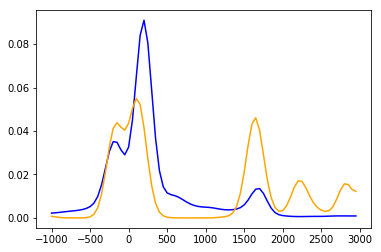

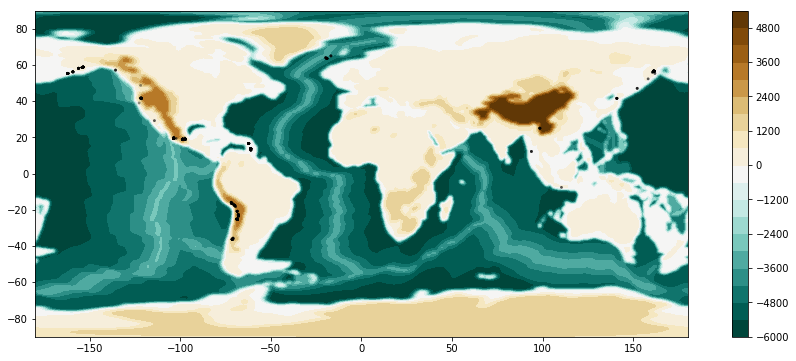

-5543.83028201 5100.0
Time 10 Ma | 257868 valid records


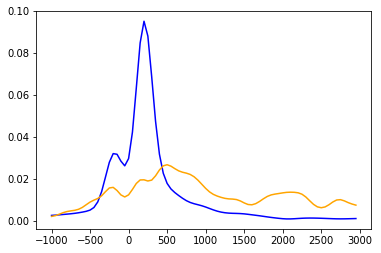

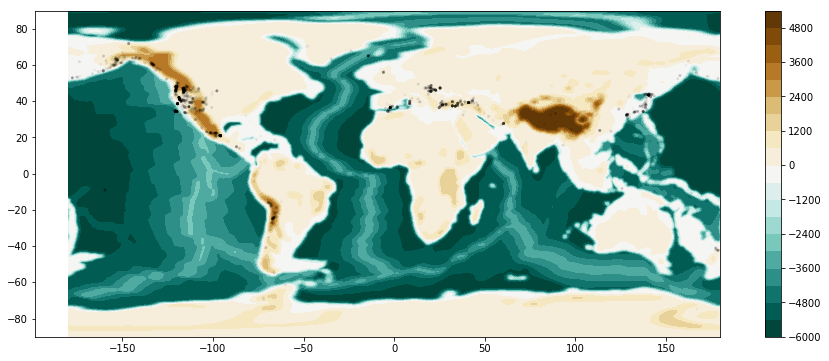

-5507.79416301 5100.0
Time 20 Ma | 255132 valid records


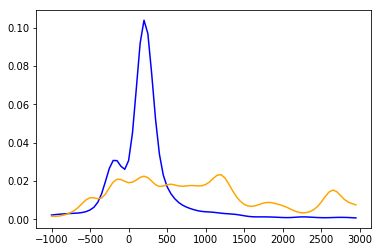

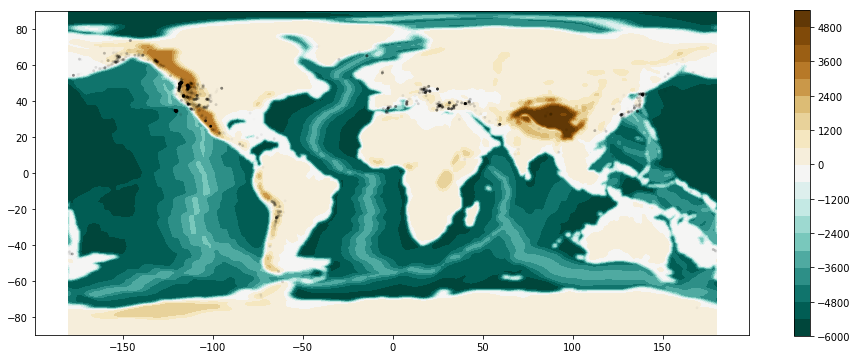

-5504.41297693 5056.76281888
Time 30 Ma | 146490 valid records


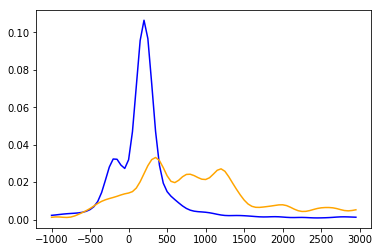

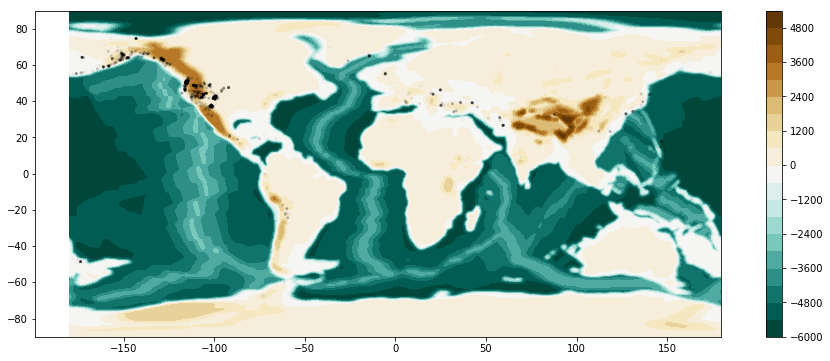

-5610.50306236 5085.91681721
Time 40 Ma | 141531 valid records


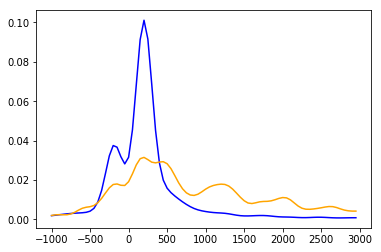

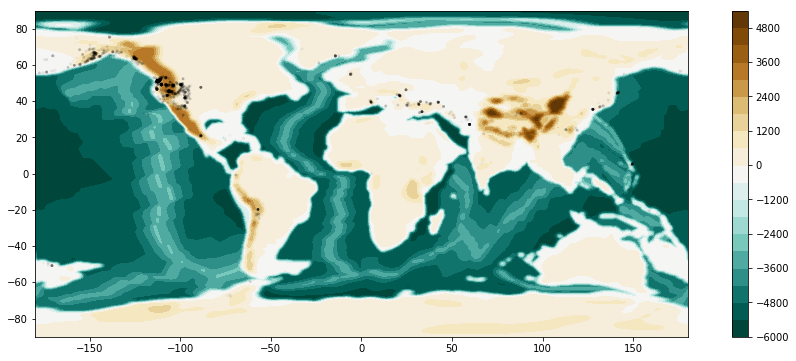

-5406.03688531 3399.87306553
Time 50 Ma | 135717 valid records


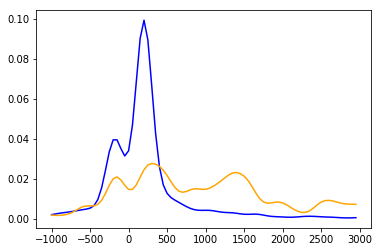

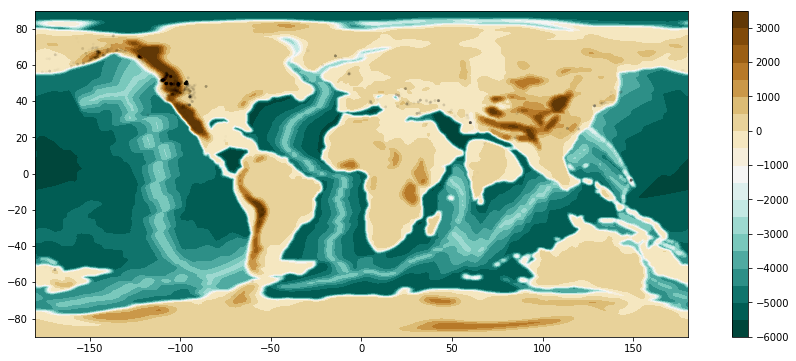

-5538.22339562 3398.3598234
Time 60 Ma | 113259 valid records


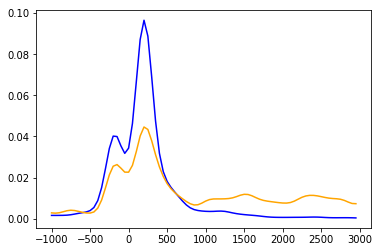

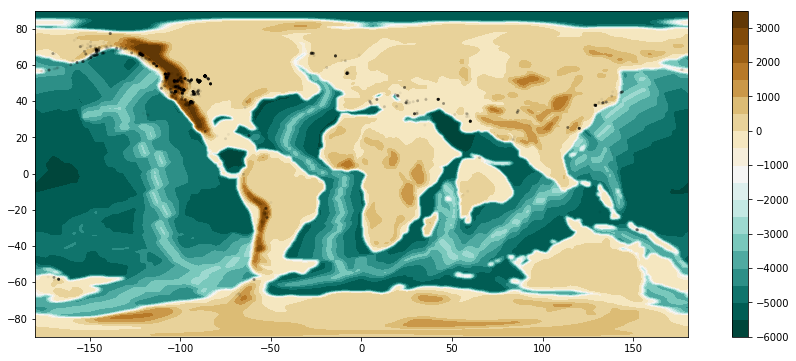

-5180.71372244 3399.81643727
Time 70 Ma | 119814 valid records


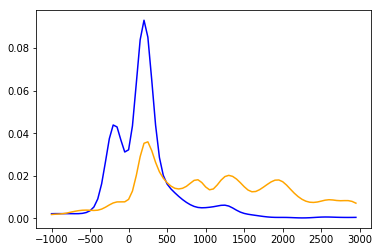

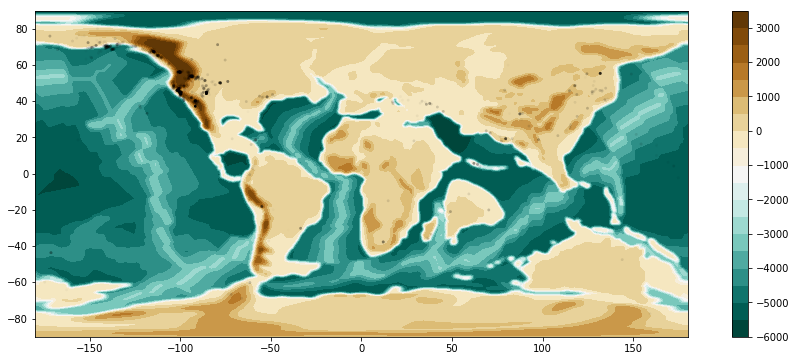

-5612.74778434 3398.86085541
Time 80 Ma | 119301 valid records


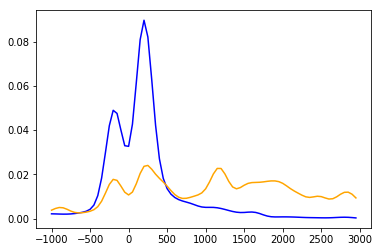

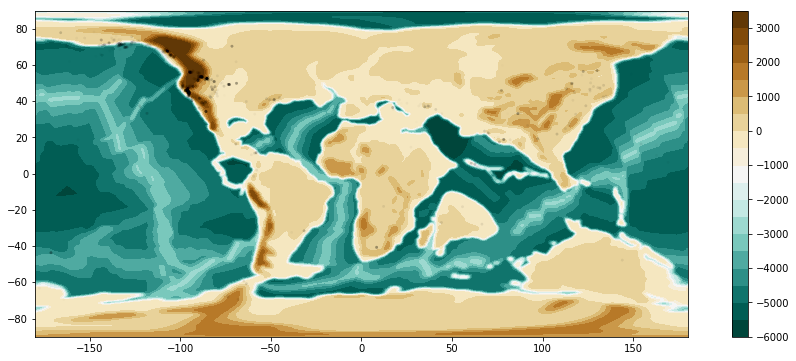

-5607.19394189 3400.0
Time 90 Ma | 122493 valid records


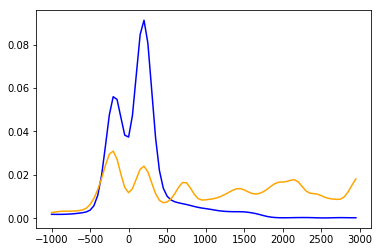

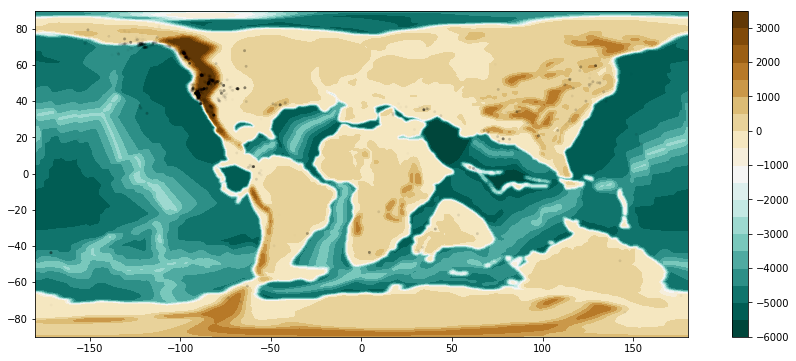

-5621.54111666 3399.92262336
Time 100 Ma | 121866 valid records


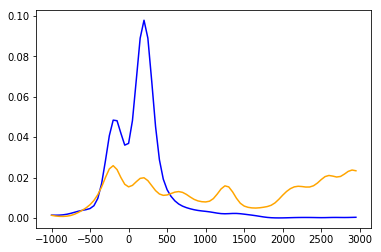

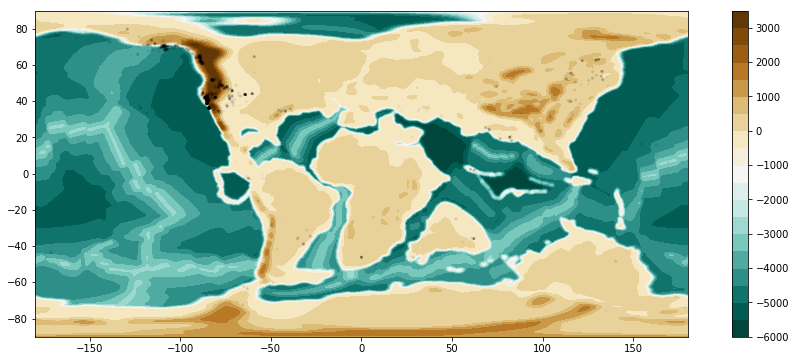

-5310.07227658 3387.74267764
Time 110 Ma | 123234 valid records


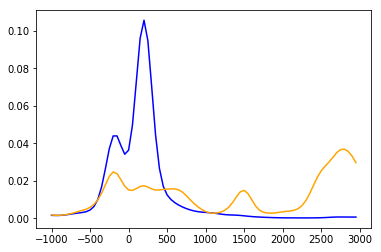

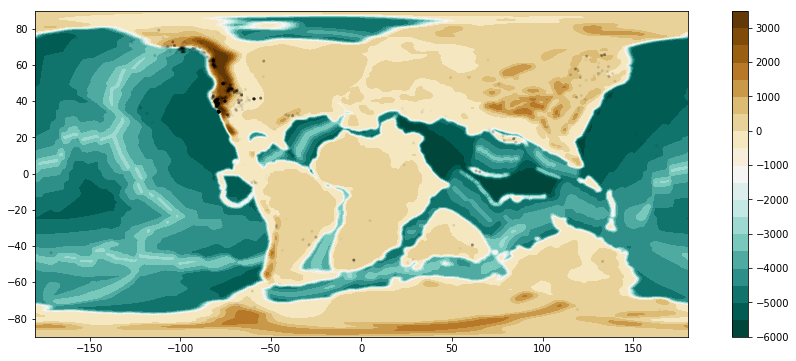

-5473.11229862 3329.70256172
Time 120 Ma | 121239 valid records


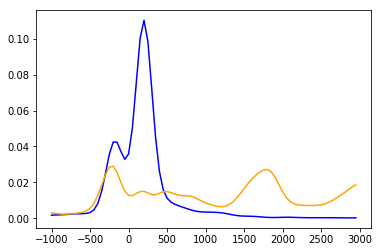

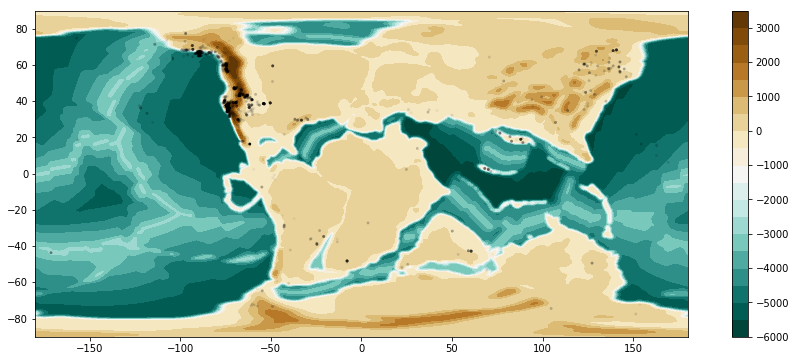

-5366.38204079 3313.29504894
Time 130 Ma | 117534 valid records


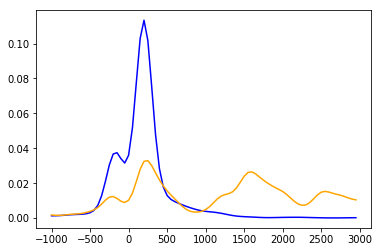

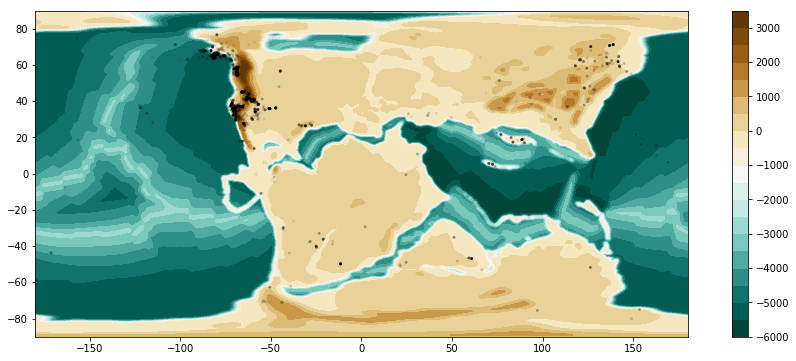

-5554.38044584 3400.0
Time 140 Ma | 118332 valid records


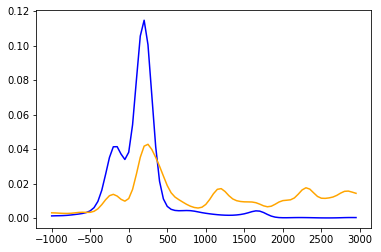

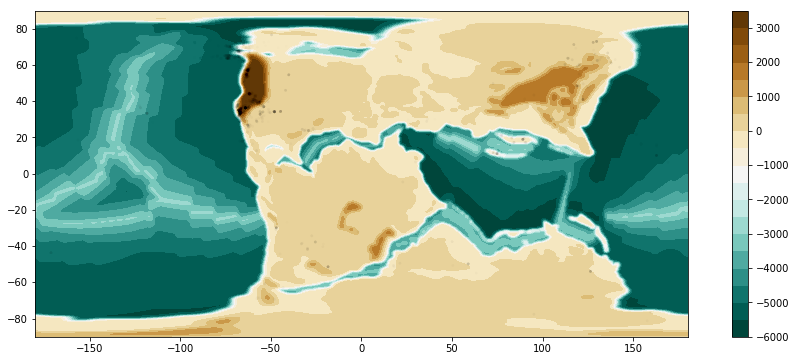

-5553.66395391 3361.48690789
Time 150 Ma | 81111 valid records


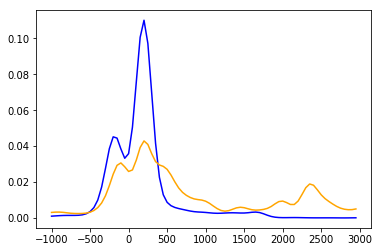

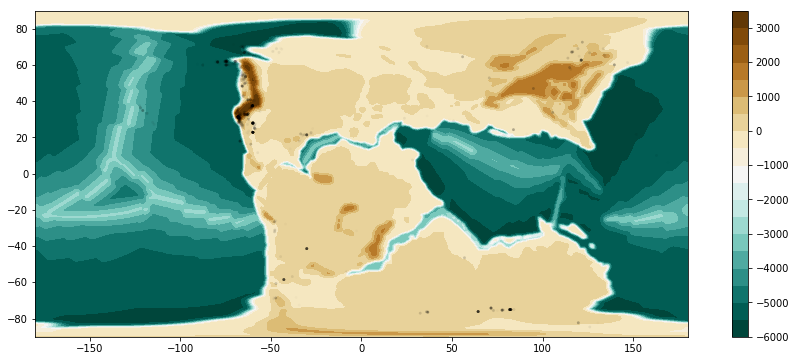

In [9]:
random_points = PointDistributionOnSphere(distribution_type='random',N=10000)

time_list = np.arange(0,160,10)


for reconstruction_time in time_list: 
    comparison_time = reconstruction_time

    pts = pygplates.partition_into_plates(static_polygons, rotation_model, random_points.meshnode_feature, reconstruction_time=reconstruction_time,
                                          properties_to_copy = [])

    pts = pts[:-1]

    randlo = []; randla = []
    for pt in pts:
        randlo.extend(pt.get_geometry().to_lat_lon_array()[:,1])
        randla.extend(pt.get_geometry().to_lat_lon_array()[:,0])
    #plt.plot(randlo,randla,'.')

    grdfile = '../../../cloudstor/Shared/Paleotopography_Grids/paleotopobathy_smooth_%0.2fMa.nc' % comparison_time

    ptopo = GplatesRaster(grdfile)

    pbdb_topo = ptopo.sample(np.array(randlo), np.array(randla))
    print pbdb_topo.min(), pbdb_topo.max()

    bc=np.arange(-1000,3000,50)
    h = ptv.kde_sklearn(pbdb_topo,bc,bandwidth=100)
    plt.plot(bc,h/np.sum(h),color='blue')
    #plt.hist(np.array(pbdb_topo),bins=bc)
    #plt.show()

    andesites_subset = andesites[(andesites['MAX AGE']>comparison_time) 
                                 & (andesites['MIN AGE']<comparison_time)]

    print 'Time %d Ma | %s valid records' % (comparison_time,andesites_subset.size)

    rla,rlo = ptv.reconstruct_dataframe(andesites_subset, static_polygons, rotation_model, comparison_time,
                                        longitude_field_name='LONGITUDE',
                                        latitude_field_name='LATITUDE') 

    bc,h = ptv.indicator_z_distribution(andesites_subset,
                                        static_polygons,
                                        rotation_model, grdfile,
                                        comparison_time,
                                        longitude_field_name='LONGITUDE',
                                        latitude_field_name='LATITUDE')

    plt.plot(bc,h/np.sum(h),color='orange')
    plt.show()


    ptv.plot_points_on_paleotopography(andesites_subset, static_polygons, rotation_model, 
                                       grdfile, comparison_time, weighting='alpha',
                                       longitude_field_name='LONGITUDE',
                                       latitude_field_name='LATITUDE',
                                       min_age_field_name='MIN AGE',
                                       max_age_field_name='MAX AGE')



Time 0 Ma | 31578 valid records
0.00 Ma


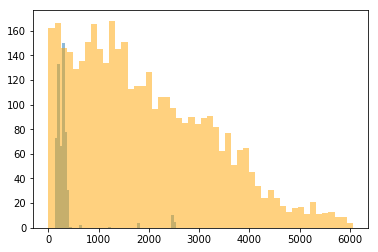

Time 10 Ma | 257868 valid records
10.00 Ma


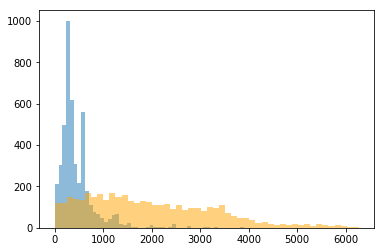

Time 20 Ma | 255132 valid records
20.00 Ma


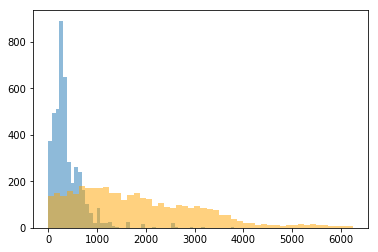

Time 30 Ma | 146490 valid records
30.00 Ma


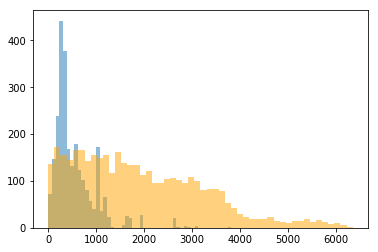

Time 40 Ma | 141531 valid records
40.00 Ma


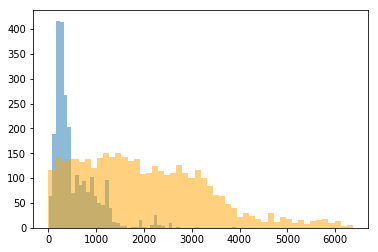

Time 50 Ma | 135717 valid records
50.00 Ma


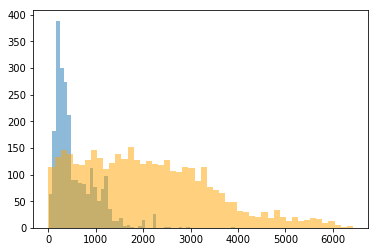

Time 60 Ma | 113259 valid records
60.00 Ma


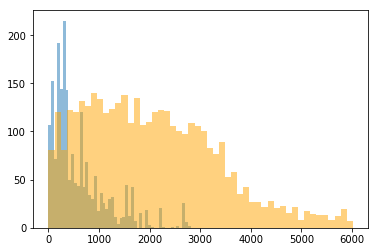

Time 70 Ma | 119814 valid records
70.00 Ma


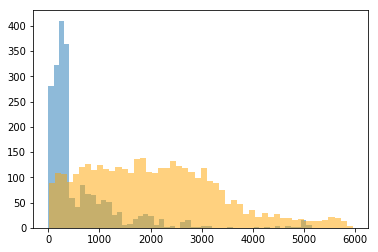

Time 80 Ma | 119301 valid records
80.00 Ma


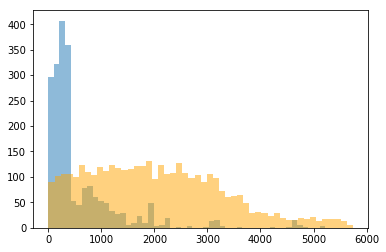

Time 90 Ma | 122493 valid records
90.00 Ma


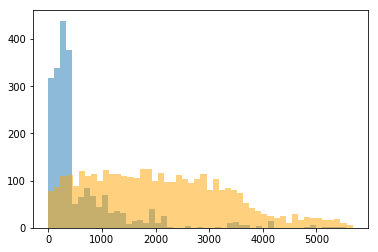

Time 100 Ma | 121866 valid records
100.00 Ma


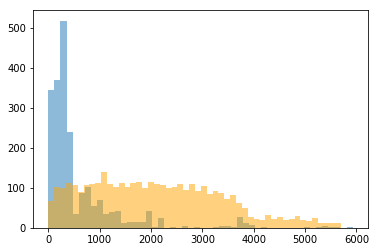

Time 110 Ma | 123234 valid records
110.00 Ma


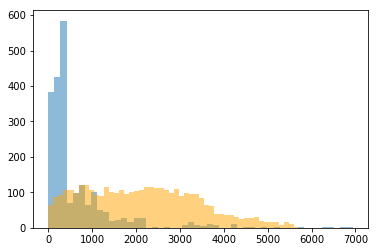

Time 120 Ma | 121239 valid records
120.00 Ma


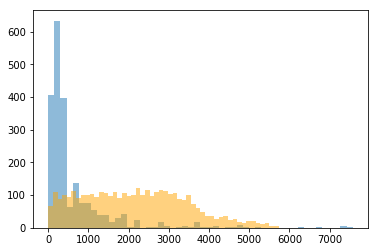

Time 130 Ma | 117534 valid records
130.00 Ma


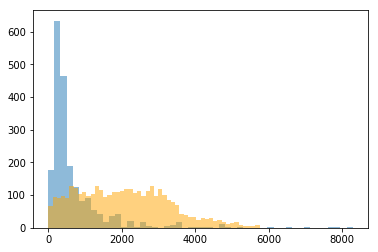

Time 140 Ma | 118332 valid records
140.00 Ma


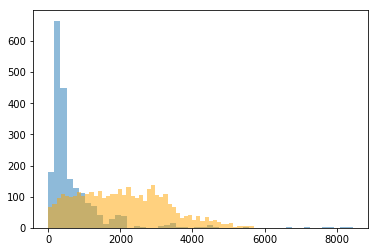

Time 150 Ma | 81111 valid records
150.00 Ma


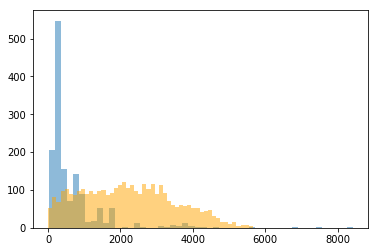

Time 160 Ma | 79971 valid records
160.00 Ma


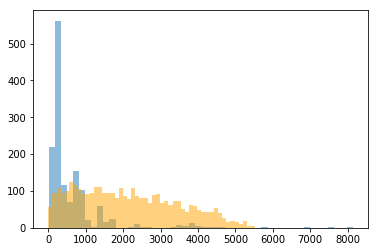

Time 170 Ma | 78717 valid records
170.00 Ma


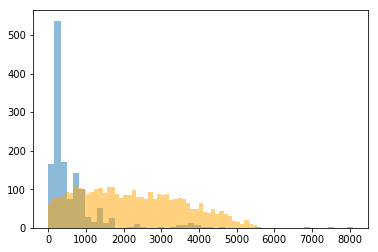

Time 180 Ma | 79287 valid records
180.00 Ma


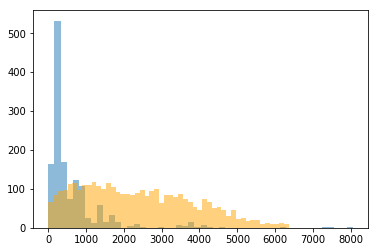

Time 190 Ma | 78831 valid records
190.00 Ma


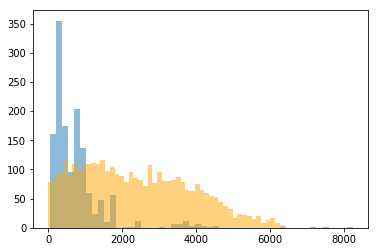

Time 200 Ma | 77976 valid records
200.00 Ma


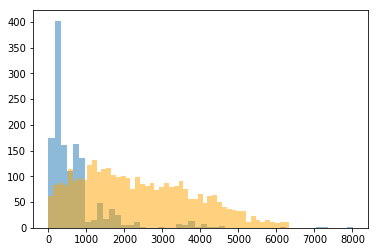

Time 210 Ma | 50901 valid records
210.00 Ma


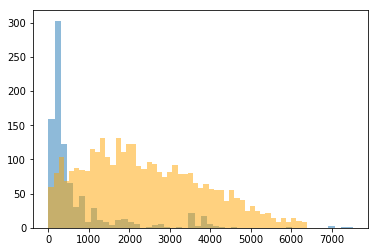

Time 220 Ma | 50901 valid records
220.00 Ma


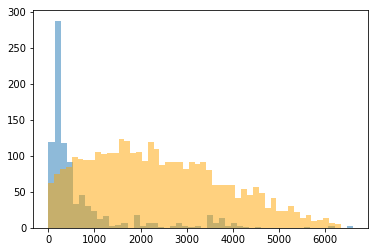

Time 230 Ma | 50958 valid records
230.00 Ma


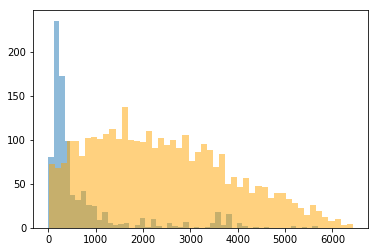

Time 240 Ma | 50616 valid records
240.00 Ma


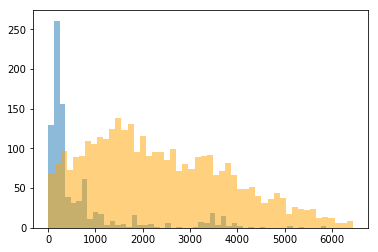

Time 250 Ma | 24453 valid records
250.00 Ma


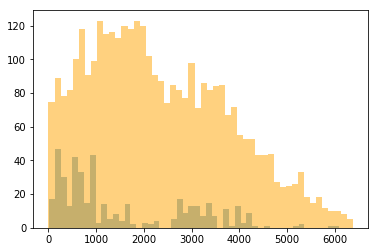

Time 260 Ma | 27303 valid records
260.00 Ma


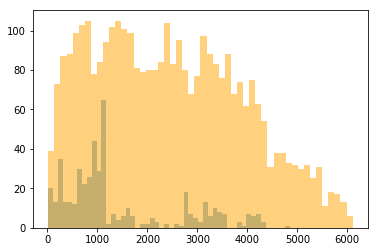

Time 270 Ma | 27303 valid records
270.00 Ma


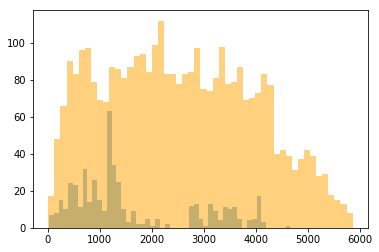

Time 280 Ma | 27873 valid records
280.00 Ma


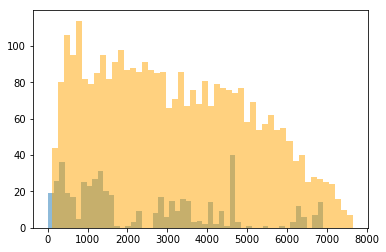

Time 290 Ma | 27702 valid records
290.00 Ma


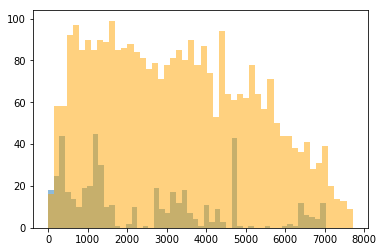

Time 300 Ma | 35169 valid records
300.00 Ma


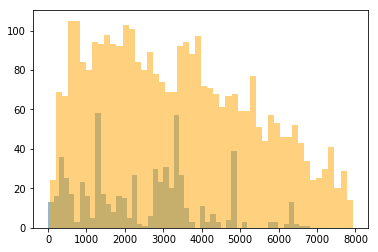

Time 310 Ma | 35169 valid records
310.00 Ma


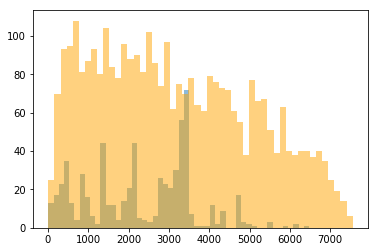

Time 320 Ma | 38760 valid records
320.00 Ma


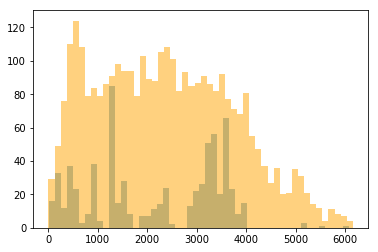

Time 330 Ma | 26049 valid records
330.00 Ma


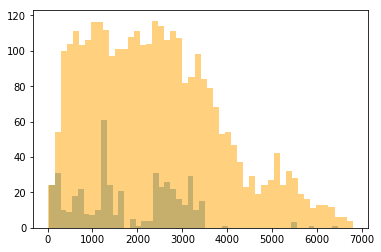

Time 340 Ma | 26106 valid records
340.00 Ma


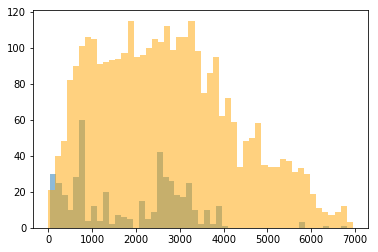

Time 350 Ma | 26106 valid records
350.00 Ma


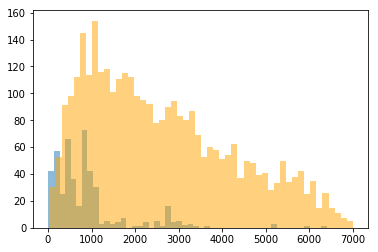

Time 360 Ma | 30438 valid records
360.00 Ma


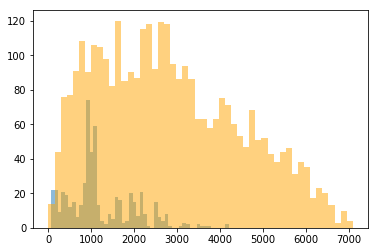

Time 370 Ma | 30324 valid records
370.00 Ma


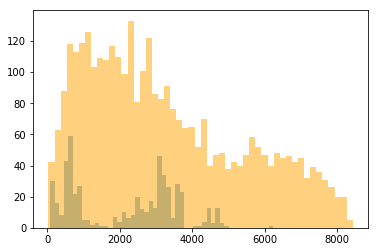

Time 380 Ma | 30267 valid records
380.00 Ma


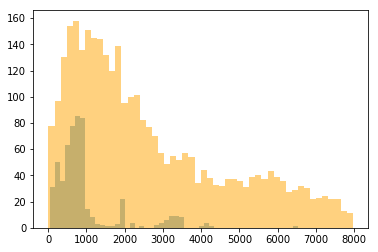

Time 390 Ma | 31692 valid records
390.00 Ma


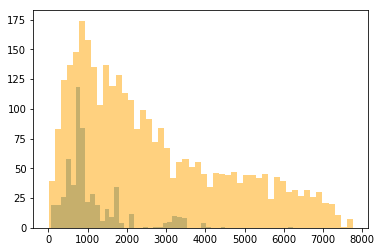

In [19]:


def nearest_feature(point,shared_sub_segments):
    # The minimum distance to all features and the nearest feature.
    min_distance_to_all_features = None
    nearest_feature = None

    for shared_sub_segment in shared_sub_segments:        

        # Get the minimum distance from point to the current reconstructed geometry.
        min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                point,
                shared_sub_segment.get_geometry(),
                min_distance_to_all_features)

        # If the current geometry is nearer than all previous geometries then
        # its associated feature is the nearest feature so far.
        if min_distance_to_feature is not None:
            min_distance_to_all_features = min_distance_to_feature
            nearest_feature = shared_sub_segment
                
    return min_distance_to_all_features



for reconstruction_time in np.arange(0,400,10):
    
    andesites_subset = andesites[(andesites['MAX AGE']>reconstruction_time) 
                                 & (andesites['MIN AGE']<reconstruction_time)]

    print 'Time %d Ma | %s valid records' % (reconstruction_time,andesites_subset.size)

    rla,rlo = ptv.reconstruct_dataframe(andesites_subset, 
                                        Ma2016.static_polygons, Ma2016.rotation_model, 
                                        reconstruction_time,
                                        longitude_field_name='LONGITUDE',
                                        latitude_field_name='LATITUDE') 
    
    print '%0.2f Ma' % reconstruction_time
    
    snapshot = Ma2016.plate_snapshot(reconstruction_time)

    resolved_subduction_segments = []
    for resolved_topological_section in snapshot.resolved_topological_sections:   
        for shared_sub_segment in resolved_topological_section.get_shared_sub_segments():
            if shared_sub_segment.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
                resolved_subduction_segments.append(shared_sub_segment)

    distances = []
    for lat,lon in zip(rla,rlo):

        dist = nearest_feature(pygplates.PointOnSphere(lat,lon),
                               resolved_subduction_segments)
        distances.append(dist*pygplates.Earth.mean_radius_in_kms)
        
        
    pts = pygplates.partition_into_plates(Ma2016.continent_polygons, Ma2016.rotation_model, 
                                          random_points.meshnode_feature, reconstruction_time=reconstruction_time,
                                          properties_to_copy = [])

    pts = pts[:-1]

    randlo = []; randla = []
    for pt in pts:
        randlo.extend(pt.get_geometry().to_lat_lon_array()[:,1])
        randla.extend(pt.get_geometry().to_lat_lon_array()[:,0])
        
    distances2 = []
    for lat,lon in zip(randla,randlo):

        dist = nearest_feature(pygplates.PointOnSphere(lat,lon),
                               resolved_subduction_segments)
        distances2.append(dist*pygplates.Earth.mean_radius_in_kms)
        
    plt.hist(distances,bins=50,alpha=0.5)
    plt.hist(distances2,bins=50,color='orange',alpha=0.5)
    plt.show()
        
        

Time 50 Ma | 135717 valid records


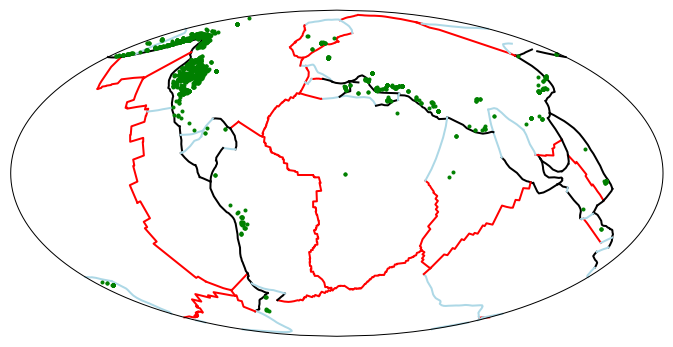

In [58]:
import cartopy.crs as ccrs

reconstruction_time = 50

snapshot = Ma2016.plate_snapshot(reconstruction_time)

andesites_subset = andesites[(andesites['MAX AGE']>reconstruction_time) 
                             & (andesites['MIN AGE']<reconstruction_time)]

print 'Time %d Ma | %s valid records' % (reconstruction_time,andesites_subset.size)

rla,rlo = ptv.reconstruct_dataframe(andesites_subset, 
                                    Ma2016.static_polygons, Ma2016.rotation_model, 
                                    reconstruction_time,
                                    longitude_field_name='LONGITUDE',
                                    latitude_field_name='LATITUDE') 

plt.figure(figsize=(12,6))

ax = snapshot.plot()

ax.plot(rlo,rla,'g.',transform=ccrs.PlateCarree())

plt.show()


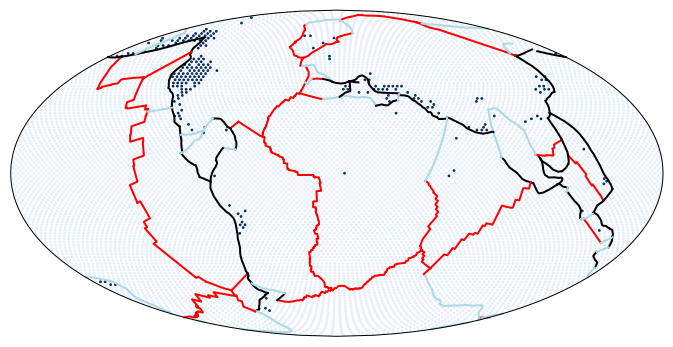

In [86]:
#andesites_acpd = AgeCodedPointDataset(andesites, field_mapping = {'longitude_field':'LONGITUDE',
#                                                                  'latitude_field':'LATITUDE',
#                                                                  'max_age_field':'MAX AGE', 
#                                                                  'min_age_field':'MIN AGE'})

# Apply equal area binning to the andesites points 

equal_area_points = PointDistributionOnSphere(distribution_type='healpix', N=32)

target_features = [pygplates.PointOnSphere(lat,lon) for lat,lon in zip(rla,rlo)]

heatmap = equal_area_points.point_feature_heatmap(target_features)


plt.figure(figsize=(12,6))

ax = snapshot.plot()

ax.scatter(equal_area_points.longitude,
           equal_area_points.latitude, 
           c=heatmap, edgecolors='', s=8, cmap=plt.cm.Blues, vmin=-0.1,vmax=1,
           transform=ccrs.PlateCarree())

plt.show()